# 3REQ system

Requirement analysis system.

The flow is presented in the following figure: 

<img src="flow.png" alt="drawing" width="700"/>

Summary:
1. Extract sections that contain words like "latency"
2. Find if they resemble requirements or not
3. Check if they are specific kinds of requirements (like signalling)
4. Write new requirements based on the text in these sections. 

In [1]:
# Importing required libraries

# docx2python is used to extract text, images, tables, and other data from .docx files
from docx2python import docx2python

# os module provides functions for interacting with the operating system
import os

# numpy is used for mathematical operations on large, multi-dimensional arrays and matrices
import numpy as np

# pandas is used for data manipulation and analysis
import pandas as pd

# TSNE from sklearn.manifold is used for dimensionality reduction
from sklearn.manifold import TSNE

# matplotlib.pyplot is used for creating static, animated, and interactive visualizations in Python
import matplotlib.pyplot as plt

# SentenceTransformer is used for training and using transformer models for generating sentence embeddings
from sentence_transformers import SentenceTransformer

# tqdm is used to make loops show a smart progress meter
from tqdm import tqdm

# torch is the main package in PyTorch, it provides a multi-dimensional array with support for autograd operations like backward()
import torch

# AutoModelForCausalLM, AutoTokenizer, pipeline are from the transformers library by Hugging Face which provides state-of-the-art machine learning models like BERT, GPT-2, etc.
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline

# euclidean distance and cosine distance
from scipy.spatial import distance

# random generator for the last figure
import random

In [2]:
# suppress warnings
import warnings

warnings.filterwarnings("ignore")

## Step 1: List the documents's sections with "latency"

In the first step, we go through the documents in the folder "input_standards" and we extract which sections of these documents contain th word "latency". We store the results in a dictionary.

In [3]:
def extractLatencySections(doc):
    strSectionTitle = ""
    dictSections = {}
    listLatency = []
    skippedSections = 0

    doc_result = docx2python(doc,paragraph_styles = True, html=True)

    # we iterate over all lines
    # look for the section titles (which have the tag <h1>, <h2>, <h3>, etc.)
    # then we add the content of each section to the dictionary
    # and if there is a word "latency" somewhere in the section, we add the section title to the listLatency
    for oneLine in tqdm(doc_result.text.split('\n')):
        if "<h" in oneLine:
            strSectionTitle = oneLine
            dictSections[strSectionTitle] = []

        if strSectionTitle != "":  
            dictSections[strSectionTitle].append(oneLine)

        keywordsInLine = ["latency", "latencies", "delay"]
        keywordsInSections = ["references", "introduction", "definition", "abstract", "conclusion", "acknowledgements", "appendix", "table of contents", "table of figures", "table of tables", "table of contents", "table of figures", "table of tables", "bibliography", "index", "glossary", "list of figures", "list of tables", "list of abbreviations", "list of symbols", "list of terms", "list of equations", "list of algorithms", "list of acronyms", "list of illustrations", "list of appendices"]

        if any(word in oneLine.lower() for word in keywordsInLine) and not any(word in strSectionTitle.lower() for word in keywordsInSections): 
            listLatency.append(strSectionTitle)
        else:
            skippedSections += 1

            
    # remove the keys from the dictionary if they are not part of the listLatency
    # as we want to get only the relevant sections, i.e., the one with the word latency
    for key in list(dictSections.keys()):
        if key not in listLatency:
            del dictSections[key]

    # print("Skipped sections: ", skippedSections)

    # return the dictionary with the relevant sections
    return dictSections


In [4]:
docInputFolder = "./23_standards"

# this is the return list of all the lines in the document
lstAllLines = []

# for each .docx file in the input folder
# extract the sections with latency using the extractLatencySections function
# and print the sections
for doc in tqdm(os.listdir(docInputFolder)):    

    if doc.endswith(".docx"):
        #print(f"Processing {doc}")

        # since things can go wrong with the latency library, 
        # we use a try except block to avoid the program to stop
        try: 
            dictSections = extractLatencySections(os.path.join(docInputFolder, doc))
        
            # we list the content
            # as a long list of sections 
            for key in dictSections:

                lstOneLine = [key, doc]

                for line in dictSections[key]:
                    lstOneLine.append(line)
                    
                lstAllLines.append(lstOneLine)

        except Exception as e:
            print(f"Error with {doc}: {e}")

100%|██████████| 38/38 [01:23<00:00,  2.20s/it]


In [5]:
# model = SentenceTransformer("all-MiniLM-L6-v2")
# model = SentenceTransformer("sentence-transformers/gtr-t5-xxl")
model = SentenceTransformer("sentence-t5-large")

# list with all embeddings for the sections
lstEmbeddings = []
iCounter = 0

for oneLine in tqdm(lstAllLines):

    # the content of the section starts on the third position of the list
    sentences = oneLine[3:]

    # Sentences are encoded by calling model.encode()
    embeddings = model.encode(sentences)
    
    # Print the average embeddings for all the sentences 
    # in this section
    avg_embeddings = embeddings.mean(axis=0)
    
    lstOneLine = [oneLine[0], oneLine[1], 2, str(sentences).replace("$", "_").replace("\n", "_"), avg_embeddings]

    lstEmbeddings.append(lstOneLine)

    iCounter += 1
    # the code below is for debug only
    # in case we want to stop the loop after a certain number of iterations
    #if iCounter == 100:
    #    break

100%|██████████| 308/308 [03:48<00:00,  1.35it/s]


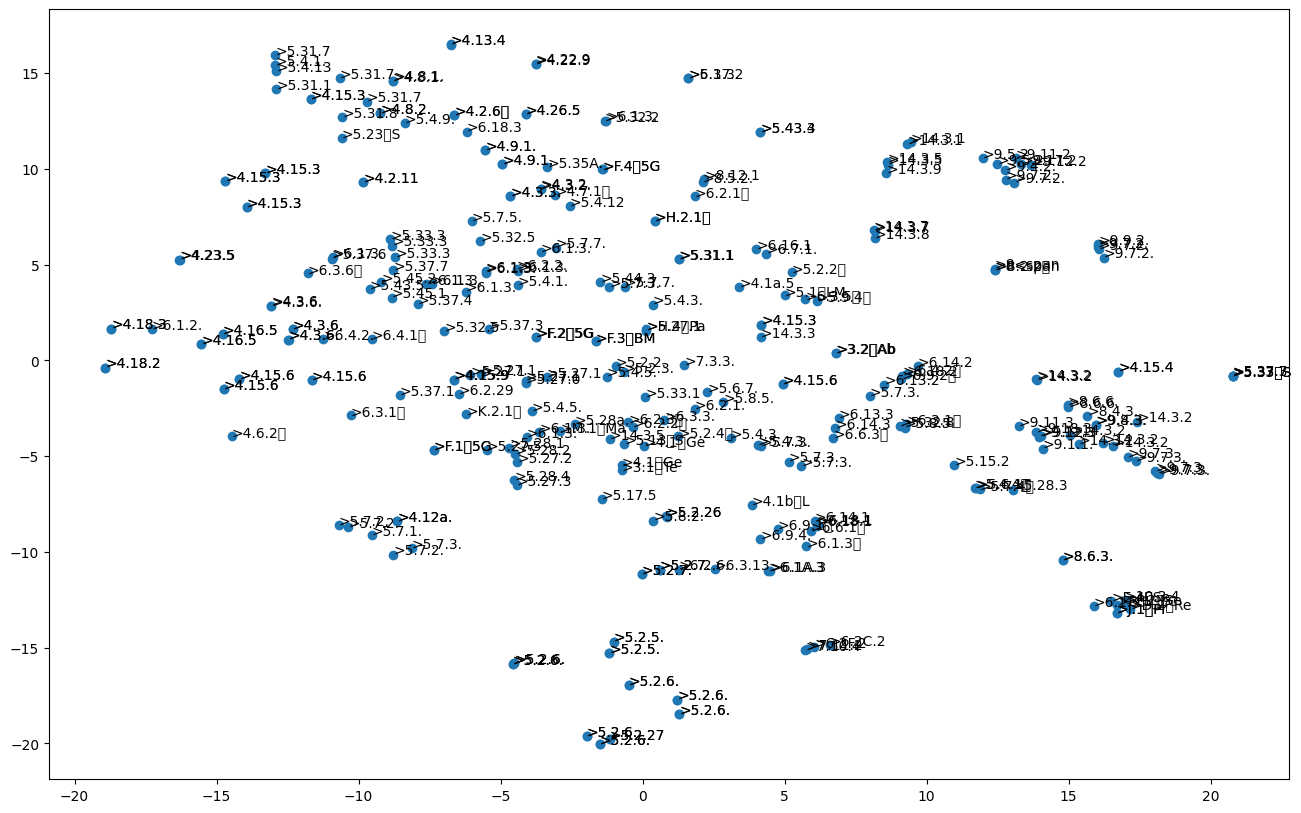

In [6]:
# let's plot these average embeddings using t-SNE

# we create a list with the embeddings
lstEmbeddingsNP = np.array([x[4] for x in lstEmbeddings])

# we use t-SNE to reduce the dimensionality of the embeddings
tsne = TSNE(n_components=2, verbose=0, perplexity=12, n_iter=300)
tsne_results = tsne.fit_transform(lstEmbeddingsNP)

# we plot the t-SNE results
plt.figure(figsize=(16,10))

plt.scatter(tsne_results[:,0], tsne_results[:,1])

# Add labels to each dot
for i, label in enumerate([x[0] for x in lstEmbeddings]):
    plt.text(tsne_results[i, 0], tsne_results[i, 1], label[3:10])


plt.show()

## Step 2: Find the relevant sections

In this step, we take the sections identified in Step 1 and we compare them to a list of right and wrong requirements. The list is stored in the file List.xlsx

In [8]:
# open the file List.xlsx using pandas
# and read the workshop NR
df = pd.read_excel("req_classes.xlsx", sheet_name="R_NR")

# convert the dataframe to a list of lists
lstReference = df.values.tolist()

lstReference[0]

['L4S (Low Latency, Low Loss and Scalable Throughput) is described in IETF RFC 9330, IETF RFC 9331 and IETF RFC 9332.',
 1]

In [9]:
# list with all embeddings for the sections
lstEmbeddingsRef = []

for oneLine in tqdm(lstReference):

    # the content of the section starts on the third position of the list
    sentences = oneLine[0]

    # Sentences are encoded by calling model.encode()
    embeddings = model.encode(sentences)
    
    # Print the average embeddings for all the sentences 
    # in this section
    avg_embedding = embeddings
    
    lstOneLine = [oneLine[0], 'REF', oneLine[1], oneLine[1], avg_embedding]

    lstEmbeddingsRef.append(lstOneLine)

100%|██████████| 55/55 [00:01<00:00, 38.88it/s]


In [10]:
# concatenate the two lists
lstEmbeddingsAll = lstEmbeddings + lstEmbeddingsRef

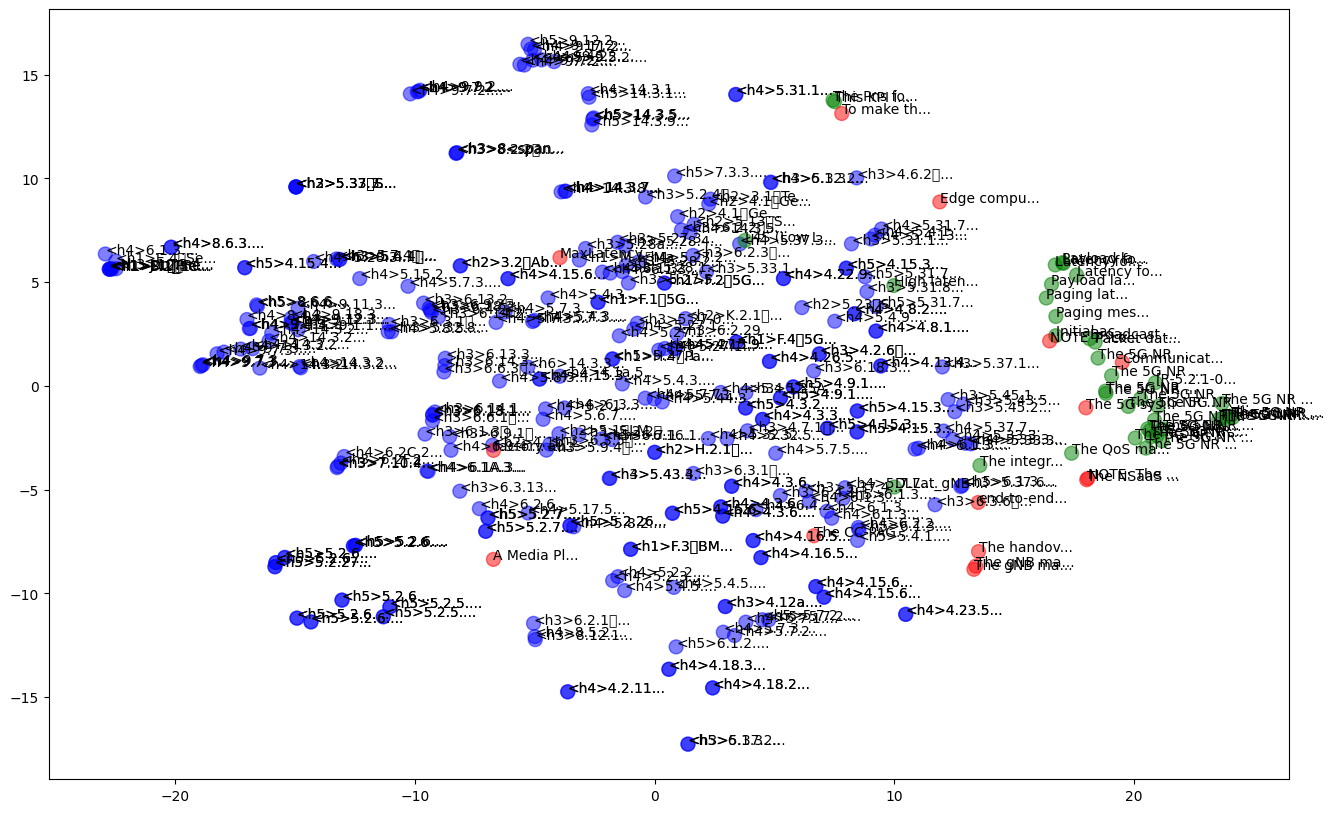

In [11]:
# let's plot these average embeddings using t-SNE

# we create a list with the embeddings
lstEmbeddingsNP = np.array([x[4] for x in lstEmbeddingsAll])

# we use t-SNE to reduce the dimensionality of the embeddings
tsne = TSNE(n_components=2, verbose=0, perplexity=12, n_iter=300)
tsne_results = tsne.fit_transform(lstEmbeddingsNP)

# Create a color map based on x[2]
color_map = {0: 'red', 1: 'green', 2: 'blue'}
colors = [color_map[x[2]] for x in lstEmbeddingsAll]

# we plot the t-SNE results
plt.figure(figsize=(16,10))

plt.scatter(tsne_results[:,0], tsne_results[:,1],c=colors, s=100, alpha=0.5)

# Add labels to each dot
for i, label in enumerate([x[0] for x in lstEmbeddingsAll]):
    plt.text(tsne_results[i, 0], tsne_results[i, 1], label[:10]+'...')


plt.show()

In [12]:
from sklearn.metrics.pairwise import euclidean_distances

# for each line in lstEmbeddings
# we calculate the euclidean distance with each line in lstEmbeddingsRef

lstDistPos = []
lstDistNeg = []

lstRelevant = []

for oneLine in tqdm(lstEmbeddings):    
    for oneLineRef in lstEmbeddingsRef:
        if oneLineRef[2] == 1:
            # euclidean distance between the two embeddings
            dist = distance.cosine(oneLine[4], oneLineRef[4])
            lstDistPos.append(dist)
        if oneLineRef[2] == 0:
            # euclidean distance between the two embeddings
            dist = distance.cosine(oneLine[4], oneLineRef[4])
            lstDistNeg.append(dist)
    
    # now calculate the average for both lists
    avgDistPos = np.mean(lstDistPos)
    avgDistNeg = np.mean(lstDistNeg)

    if avgDistPos < avgDistNeg:
        #print(f"Section {oneLine[0]} is relevant")
        # add the class to the list
        oneLine.append(1)
        lstRelevant.append(oneLine)
    else:
        #print(f"Section {oneLine[0]} is not relevant")
        # add the class to the list
        oneLine.append(0)

                

100%|██████████| 308/308 [00:00<00:00, 1711.00it/s]


In [13]:
print(f'Relevant sections: {len(lstRelevant)}')

Relevant sections: 308


In [14]:
lstEmbeddings[0]

['<h4>4.1a.5.1\tTypes of event</h4>',
 '23273-i20.docx',
 2,
 "['', 'The following types of event are defined for a deferred location request.', '', 'a)\\tUE availability: Any event in which the 5GCN has established a contact with the UE. This event is considered to be applicable when the UE is temporarily unavailable due to inaction by the user, or for temporarily loss of radio connectivity or IMSI detach and so on. The UE Available event only requires one response to an LCS client/AF and after this response, the UE Available event is concluded.', '', 'b)\\tArea: An event where the UE enters, leaves or remains within a pre-defined geographical area. At least one type of area event can be defined (i.e. entering, leaving or remaining within the area). The LCS client or AF may define the target area as a geographical area or as a geopolitical name of an area. The PLMN may translate and define the target area as the identities of one or more radio cells or tracking areas. The LCS client o

In [15]:
# here we save all the relevant sections to an Excel file
# and the non-relevant ones too
import pandas as pd

dfOutput = pd.DataFrame(lstEmbeddings, columns=["Section", "Document", "Class", "Content", "Embedding", "Relevance"])

dfOutput.to_excel("./output.xlsx", index=False)

## Step 3: Find which requirements are impacted

In this step, we compare the relevant sections with the existing requirements. Based on the distance, we can determine which requirements are impacted. The requirements are provided as a separete list. 

In [16]:
print(f'Percentage relevant: {len(lstRelevant)/len(lstEmbeddings)*100:.2f}%')

Percentage relevant: 100.00%


In [18]:
# read the requirements from the excel file requirements.xlsx, worksheet LR
df = pd.read_excel("req_classes.xlsx", sheet_name="LR")

# convert to list
lstRequirements = df.values.tolist()
lstRequirements[0]

# now we calculate the embeddings for each of these requirements
lstEmbeddingsReq = []

for oneLine in tqdm(lstRequirements):
    
        # the content of the section starts on the third position of the list
        sentences = oneLine[1]
    
        # Sentences are encoded by calling model.encode()
        embeddings = model.encode(sentences)
        
        # Print the average embeddings for all the sentences 
        # in this section
        avg_embedding = embeddings
        
        lstOneLine = [oneLine[0], 'latency', oneLine[1], oneLine[1], avg_embedding]
    
        lstEmbeddingsReq.append(lstOneLine)

  0%|          | 0/16 [00:00<?, ?it/s]

100%|██████████| 16/16 [00:00<00:00, 26.42it/s]


In [19]:
# now we calculate the euclidean distance between the requirements and the sections
# that are relevant
lstDist = []
lstRelevantDist = []

for oneLine in tqdm(lstRelevant):
    for oneLineReq in lstEmbeddingsReq:
        # euclidean distance between the two embeddings
        dist = distance.cosine(oneLine[4], oneLineReq[4])
        lstDist.append([oneLine[0], oneLine[1], oneLineReq[0], dist, oneLine[3]])

# now we sort the list by the distance
lstDist.sort(key=lambda x: x[2])

# and we print them
for i in range(len(lstDist)):
    print(f"Section {lstDist[i][0]} is close to requirement {lstDist[i][2]} with distance {lstDist[i][3]:.2f}")
    # add this to a list
    lstRelevantDist.append([lstDist[i][0], lstDist[i][1], lstDist[i][2], lstDist[i][3], lstDist[i][4]])

# save the list to an Excel file
dfOutput = pd.DataFrame(lstRelevantDist, columns=["Section", "Document", "Requirement", "Distance", "Content"])

# sort it by section and document
dfOutput = dfOutput.sort_values(by=["Section", "Document"])

dfOutput.to_excel("./output_requirements_distances_b.xlsx", index=False)

100%|██████████| 308/308 [00:00<00:00, 10679.32it/s]


Section <h4>4.1a.5.1	Types of event</h4> is close to requirement LR1_signalling with distance 0.20
Section <h4>4.1a.5.1	Types of event</h4> is close to requirement LR1_signalling with distance 0.22
Section <h4>4.1a.5.1	Types of event</h4> is close to requirement LR1_signalling with distance 0.19
Section <h4>4.1a.5.1	Types of event</h4> is close to requirement LR1_signalling with distance 0.19
Section <h2>4.1b	LCS Quality of Service</h2> is close to requirement LR1_signalling with distance 0.21
Section <h2>4.1b	LCS Quality of Service</h2> is close to requirement LR1_signalling with distance 0.21
Section <h2>4.1b	LCS Quality of Service</h2> is close to requirement LR1_signalling with distance 0.18
Section <h2>4.1b	LCS Quality of Service</h2> is close to requirement LR1_signalling with distance 0.19
Section <h2>5.1	LMF Discovery and Selection</h2> is close to requirement LR1_signalling with distance 0.22
Section <h2>5.1	LMF Discovery and Selection</h2> is close to requirement LR1_signalli

In [20]:
# average the distance in dfOutput per section, document and requirement
dfOutput["Distance"] = dfOutput["Distance"].astype(float)
dfGrouped = dfOutput.groupby(["Section", "Document", "Requirement", "Content"])

#convert dfGrouped to a dataframe
dfGrouped = dfGrouped.agg({"Distance": "mean"}).reset_index()

dfGrouped.to_excel("./output_requirements_distances_g.xlsx", index=False)

In [21]:
# now check the minimum distance per section and document
dfGrouped = dfGrouped.sort_values(by=["Section", "Document", "Distance"])

dfGrouped = dfGrouped.groupby(["Section", "Document"]).first().reset_index()

dfGrouped.to_excel("./output_requirements_distances_g_min.xlsx", index=False)

In [22]:
# now we turn this into a list of lists
lstRelevantDist = dfGrouped.values.tolist()

print(len(lstRelevantDist))

308


In [23]:
# convert to dataframe and save to excel lstRelevantDist
dfRelevantDist = pd.DataFrame(lstRelevantDist, columns=["Section", "Document", "Requirement", "Content", "Distance"])

dfRelevantDist.to_excel("./output_requirements_temp.xlsx", index=False)

## Step 4: Check if the requirements exist in the database

In this step, we check if the text that we identified so far is covered by the requirements that exist in the database. We use the sentence transformers to get the embeddings of the text and then we compare them to the existin sections. 

In [24]:
thresholdPartial = 0.2
thresholdCovered = 1.0

In [25]:
# read the requirements from the Excel file
dfRelevantSections = pd.read_excel("./output_requirements_temp.xlsx")

lstRelevantSections = dfRelevantSections.values.tolist()

In [26]:
lstRelevantSections[0]

['<h1>B.1\tLCS privacy selection flow rule</h1>',
 '23273-i20.docx',
 'LR1_signalling',
 '[\'\', \'A 5GS-MT-LR may be applied to more than one LCS privacy data in the LCS privacy profile, e.g. one or more privacy classes as defined in clause\\xa05.4.2.2 and LPI as defined in clause\\xa05.4.2.3. The 5GS-MT-LR may also require POI as defined in clause\\xa05.4.4. The Privacy selection flow is shown in Figure B.1-1.\', \'\', \'----media/image63.emf----\', \'\', \'Figure B.1-1: Privacy selection flow diagram\', \'\', \'\', \'\', \'\', \'Annex C (informative):\', \'PNI-NPN architecture to support location service with signalling optimisation\', \'\', \'Figure C-1 shows the PNI-NPN architecture to support location services with optimisation of signalling latency and privacy, with the corresponding functional descriptions are defined in clause\\xa05.13.\', \'\', \'When UE access the NG-RAN in the local network, during the registration procedure or service request procedure, NG-RAN selects the 

In [27]:
model = SentenceTransformer("sentence-t5-large")

# list with all embeddings for the sections
lstRelevantEmbeddings = []
iCounter = 0

for oneLine in tqdm(lstRelevantSections):

    # the content of the section starts on the third position of the list
    sentences = oneLine[3]

    # Sentences are encoded by calling model.encode()
    embeddings = model.encode(sentences)
    
    # Print the average embeddings for all the sentences 
    # in this section
    # avg_embedding = np.mean(embeddings, axis=0)
    
    lstOneLine = [oneLine[0], oneLine[1], 2, str(sentences).replace("$", "_").replace("\n", "_"), embeddings]

    lstRelevantEmbeddings.append(lstOneLine)

    iCounter += 1

100%|██████████| 308/308 [00:10<00:00, 30.46it/s]


In [29]:
# now, read the requirements from the requirements database, file 20_requirements.xlsx
dfTRequirements = pd.read_excel("existing_requirements.xlsx")

# convert to list
lstTRequirements = dfTRequirements.values.tolist()

In [30]:
lstTRequirements[0]

['Req_1',
 'Regarding support for infrastructure protection of electrical transmission, the 5G system shall support an end-to-end latency of less than 5 ms or 10 ms, as requested by the UE initiating the communication. ',
 'NOTE 1: This requirement relates to TS 22.104, chapter 5.6C Support for infrastructure protection of electrical transmission.\nNOTE 2: Whether the end-to-end latency is 5 ms or 10 ms depends on the applied voltage level. \nNOTE 3: The end-to-end latency is between two UEs, including two wireless links.',
 'Payload',
 nan]

In [31]:
# make the embeddings
model = SentenceTransformer("sentence-t5-large")

# list with all embeddings for the sections
lstTRequirementsEmbeddings = []
iCounter = 0

for oneLine in tqdm(lstTRequirements):

    # the content of the section starts on the requirement text
    sentences = oneLine[1]

    # Sentences are encoded by calling model.encode()
    embeddings = model.encode(sentences)
    
    # Print the average embeddings for all the sentences 
    # in this section
    #avg_embedding = np.mean(embeddings, axis=0)
    
    lstOneLine = [oneLine[0], oneLine[1], 2, str(sentences).replace("$", "_").replace("\n", "_"), embeddings]

    lstTRequirementsEmbeddings.append(lstOneLine)

    iCounter += 1

100%|██████████| 20/20 [00:00<00:00, 45.12it/s]


In [32]:
# average the embeddings for all the lstTRequirementsEmbeddings
lstTRequirementsEmbeddingsNP = np.array([x[4] for x in lstTRequirementsEmbeddings])

tRequirementsAvgEmbeddings = np.mean(lstTRequirementsEmbeddingsNP, axis=0)

In [33]:
# now, calculate the average distance of all the relevant sections to the average requirements
lstDist = []

for oneLine in tqdm(lstRelevantEmbeddings):
    # euclidean distance between the two embeddings
    dist = distance.cosine(oneLine[4], tRequirementsAvgEmbeddings)
    lstDist.append([oneLine[0], oneLine[1], dist, oneLine[3]])

# now we sort the list by the distance
lstDist.sort(key=lambda x: x[3])
    

100%|██████████| 308/308 [00:00<00:00, 125604.83it/s]


In [34]:
lstDist[0]

['<h2>4.1\tGeneral</h2>',
 '23548-i20.docx',
 0.116038754741146,
 '[\'\', "Edge Computing enables operator and 3rd party services to be hosted close to the UE\'s access point of attachment, so as to achieve an efficient service delivery through the reduced end-to-end latency and load on the transport network.", \'\', \'5GS supports Edge Hosting Environment (EHE) deployed in the DN beyond the PSA UPF. An EHE may be under the control of either the operator or 3rd parties.\', \'\', \'The Edge Computing features defined in this specification are applicable to PLMN(s) and to SNPN(s).\', \'\', \'The Local part of the DN in which EHE is deployed may have user plane connectivity with both a centrally deployed PSA and locally deployed PSA of same DNN. Edge Computing enablers as described in clause\\xa05.13 of TS\\xa023.501\\xa0[2], e.g. local routing and traffic steering, session and service continuity, AF influenced traffic routing, are leveraged in this specification.\', \'\', \'Edge Computin

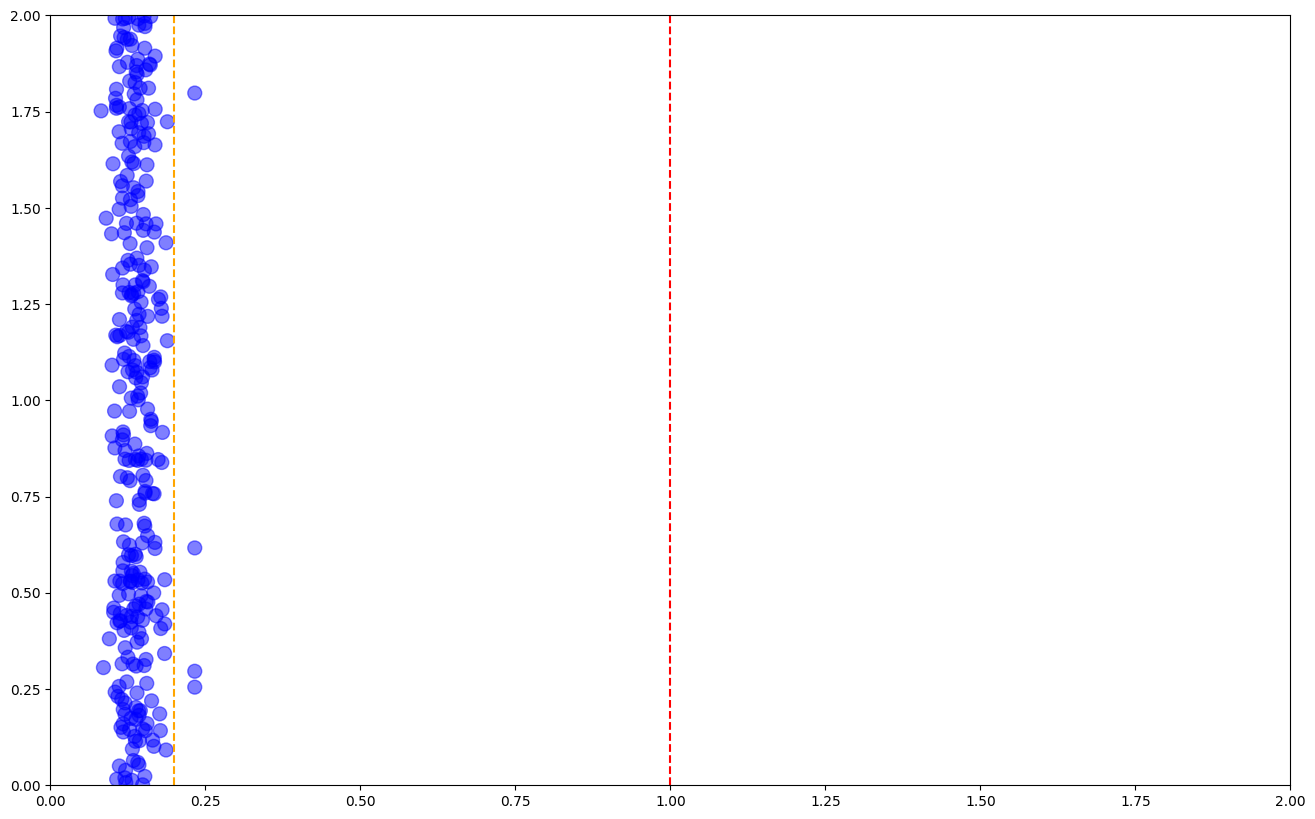

In [35]:
# Visualize the results using the scatter plot, where
# the x-axis is the distance to the average requirement
# the y-axis is always 1
# the color is red for the requirements

# Create a color map based on x[2]
color_map = {0: 'blue', 1: 'green', 2: 'red'}
colors = [color_map[0] for x in lstDist]

# we plot the t-SNE results
plt.figure(figsize=(16,10))

random.seed(42)

plt.scatter([x[2] for x in lstDist], [random.random() * 2 for x in lstDist], c=colors, s=100, alpha=0.5)

# Add labels to each dot
#for i, label in enumerate([x[3] for x in lstDist]):
#    plt.text([x[2] for x in lstDist][i], 1, label[:20]+'...', rotation='vertical')

# Add vertical lines at 0.33 and 1.0
plt.axvline(x=thresholdPartial, color='orange', linestyle='--')
plt.axvline(x=thresholdCovered, color='red', linestyle='--')

# Set the limits of the x-axis
plt.xlim(0, 2)
plt.ylim(0, 2)

plt.show()

In [36]:
# now we separate them into three lists:
# - with distance below 0.33 -- these requirements are covered
# - with distance between 0.33 and 1.0 -- these requirements are partially covered
# - with distance above 1.0 -- these requirements are not covered

lstCovered = []
lstPartiallyCovered = []
lstNotCovered = []

for oneLine in lstDist:
    if oneLine[2] < thresholdPartial:
        lstCovered.append(oneLine)
    elif oneLine[2] < thresholdCovered:
        lstPartiallyCovered.append(oneLine)
    else:
        lstNotCovered.append(oneLine)

## Step 5: create requirements based on each of these sections

In the last step, we create new requirements based on the sections identified in the previous steps.

In [44]:
torch.random.manual_seed(0)

modelInstr = AutoModelForCausalLM.from_pretrained(
    "microsoft/Phi-3-mini-128k-instruct", 
    device_map="cuda", 
    torch_dtype="auto", 
    trust_remote_code=True, 
)
tokenizerInstr = AutoTokenizer.from_pretrained("microsoft/Phi-3-mini-4k-instruct")

`flash-attention` package not found, consider installing for better performance: No module named 'flash_attn'.
Current `flash-attenton` does not support `window_size`. Either upgrade or use `attn_implementation='eager'`.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [45]:
def createRequirement(content, type, model, tokenizer):
    content1 = content.split(",")
    content1 = [x for x in content1[1:] if x not in ['', " ''", " '']"]]
    content_str = " ".join(content1)
    
    strContent = f"Based on this : {content_str}. Write the requirement in the following format 'The system shall ' "
    
    messages = [
        {"role": "user", "content": strContent},
    ]

    pipe = pipeline(
        "text-generation",
        model=model,
        tokenizer=tokenizer,
    )

    generation_args = {
        "max_new_tokens": 500,
        "return_full_text": False,
        "temperature": 0.0,
        "do_sample": False,
    }

    output = pipe(messages, **generation_args)
    
    return output[0]['generated_text']

In [46]:
lstGenerated = []
iCounter = 0

# we generate new requirements for the partially covered ones
if len(lstPartiallyCovered) > 0:
    for oneLine in tqdm(lstPartiallyCovered):
        iCounter += 1
        strRequirement = createRequirement(oneLine[3], oneLine[2], modelInstr, tokenizerInstr)
        lstGenerated.append([oneLine[0], oneLine[1], oneLine[2], oneLine[3], strRequirement])
        if iCounter % 10 == 0:
            # convert the list to a dataframe and save to excel
            dfOutput = pd.DataFrame(lstGenerated, columns=["Section", "Document", "Requirement type", "Content", "Distance", "Generated requirements"])
            dfOutput.to_excel("./output_partially_covered_generated_cont.xlsx", index=False)

100%|██████████| 4/4 [01:31<00:00, 22.91s/it]


In [40]:
# we generate new requirements for the not covered requirements
if len(lstNotCovered) > 0:
    for oneLine in tqdm(lstNotCovered):
        iCounter += 1
        if (len(oneLine[3]) < 10000):
            strRequirement = createRequirement(oneLine[3], oneLine[2], modelInstr, tokenizerInstr)
            lstGenerated.append([oneLine[0], oneLine[1], oneLine[2], oneLine[3], strRequirement])
        if iCounter % 10 == 0:
            # convert the list to a dataframe and save to excel
            dfOutput = pd.DataFrame(lstGenerated, columns=["Section", "Document", "Requirement type", "Content", "Distance", "Generated requirements"])
            dfOutput.to_excel("./output_partially_covered_generated_cont.xlsx", index=False)

In [41]:
dfOutput = pd.DataFrame(lstGenerated, columns=["Section", "Document", "Content", "Distance", "Generated requirements"])
dfOutput.to_excel("./output_partially_covered_generated.xlsx", index=False)

In [47]:
# we generate new requirements for the not covered requirements
if len(lstCovered) > 0:
    for oneLine in tqdm(lstCovered):
        iCounter += 1
        if (len(oneLine[3]) < 10000):
            strRequirement = createRequirement(oneLine[3], oneLine[2], modelInstr, tokenizerInstr)
            lstGenerated.append([oneLine[0], oneLine[1], oneLine[2], oneLine[3], strRequirement])
        if iCounter % 10 == 0:
            # convert the list to a dataframe and save to excel
            dfOutput = pd.DataFrame(lstGenerated, columns=["Section", "Document", "Requirement type", "Content", "Distance", "Generated requirements"])
            dfOutput.to_excel("./output_covered_generated_cont.xlsx", index=False)

  2%|▏         | 5/304 [01:49<1:39:58, 20.06s/it]

In [43]:
lstGenerated[0]

['<h2>5.33\tSupport for Ultra Reliable Low Latency Communication</h2>',
 '23501-i22.docx',
 0.23272037227432385,
 "['']",
 ' The system shall:\n\n1. Provide accurate and timely data processing capabilities to ensure efficient operation.\n2. Maintain data integrity and security to protect sensitive information from unauthorized access or breaches.\n3. Offer user-friendly interfaces and intuitive navigation to enhance user experience and productivity.\n4. Support scalability and flexibility to accommodate future growth and changing business needs.\n5. Implement robust error handling and recovery mechanisms to minimize downtime and data loss.\n6. Ensure compliance with relevant industry standards and regulations to maintain legal and ethical operations.\n7. Facilitate seamless integration with other systems and applications for streamlined workflows and data exchange.\n8. Deliver consistent performance and reliability to meet user expectations and operational demands.\n9. Provide comprehe